# Evaluate

The network trained by `05_Train_Sweep.ipynb` is evaluated in this notebook.

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load some packages
import os
import json
import yaml
from copy import deepcopy

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pprint
import matplotlib.pyplot as plt

# custom package
from datasets.cau_eeg_dataset import *
from datasets.cau_eeg_script import *
import models
from train import *

In [3]:
print('PyTorch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available(): print('cuda is available.')
else: print('cuda is unavailable.') 

PyTorch version: 1.11.0+cu113
cuda is available.


-----

## Load the configuration which used during train phase

In [4]:
model_name = 'zlypije8'
model_path = os.path.join('local/checkpoint', model_name)

In [5]:
with open(os.path.join(model_path, 'config.yaml'), 'r') as f:
    wandb_config = yaml.load(f, Loader=yaml.FullLoader)
    
config = {}
for k, v in wandb_config.items():
    if type(k) is str and (k.startswith('wandb') or k.startswith('_wandb')):
        continue
    config[k] = v['value']

pprint.pprint(config)

{'EKG': 'X',
 'LR': 0.00028586537399823023,
 'activation': 'gelu',
 'age_mean': 69.92779783393502,
 'age_std': 9.817569889945597,
 'awgn': 0.09612556281067966,
 'awgn_age': 0.232644717265596,
 'base_channels': 64,
 'base_stride': 3,
 'block': 'models.resnet_1d.BottleneckBlock1D',
 'conv_layers': [3, 4, 6, 3],
 'criterion': 'multi-bce',
 'crop_length': 2000,
 'crop_multiple': 2,
 'data_path': 'dataset/02_Curated_Data/',
 'dataset': 'CAUHS',
 'device': 'cuda',
 'draw_result': True,
 'dropout': 0.4741286361591117,
 'fc_stages': 3,
 'final_pool': 'average',
 'final_shape': [64, 2048, 12],
 'first_dilation': 3,
 'generator': 'models.resnet_1d.ResNet1D',
 'groups': 32,
 'history_interval': 200,
 'in_channels': 20,
 'input_norm': 'dataset',
 'iterations': 200000,
 'longer_crop_length': 20000,
 'lr_decay_gamma': 0.1721164909561929,
 'lr_decay_step': 150000,
 'meta_path': 'dataset/02_Curated_Data/metadata_debug.json',
 'minibatch': 64,
 'mixup': 0.3,
 'model': '1D-ResNeXt-5x',
 'model_index': 2

In [6]:
# preprocessing procedure was changed.. (norm, channel drop) --> (channel drop, norm)
config['signal_mean'] = np.delete(np.array(config['signal_mean']), 19, 0)
config['signal_std'] = np.delete(np.array(config['signal_std']), 19, 0)

-----

## Build the dataset

In [7]:
config['data_path'] = 'local/dataset/02_Curated_Data_210705/'
config['meta_path'] = 'local/dataset/02_Curated_Data_210705/metadata_debug.json'
config['file_format'] = 'feather'
config['minibatch'] = 256
config['crop_multiple'] = 5
config['crop_timing_analysis'] = True
config['evaluation_phase'] = True
# config['latency'] = 200 * 10  # 10 seconds
# config['longer_crop_length'] = 20000 * 2
config['device'] = device
repeat = round(50 / config['crop_multiple'])

_ = build_dataset(config, verbose=True)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
test_loader_longer = _[3]
preprocess_train = _[4]
preprocess_test = _[5]

class_label_to_name: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']

----------------------------------------------------------------------------------------------------

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia

----------------------------------------------------------------------------------------------------

Train data label distribution	: [370, 278, 183] 831
Train data label distribution	: [46, 35, 23] 104
Train data label distribution	: [47, 34, 23] 104

----------------------------------------------------------------------------------------------------

composed_train: Compose(
    EegDropEKGChannel()
    EegRandomCrop(crop_length=2000, multiple=5, latency=0, return_timing=True)
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

composed_test: Compose(
    EegDropEKGChannel()
    EegRandomCrop

-----

## Load the target model

In [8]:
config['generator'] = getattr(models, config['generator'].split('.')[-1])

if 'block' in config:
    config['block'] = getattr(models, config['block'].split('.')[-1])

model = config['generator'](**config).to(device)
model_state = torch.load(os.path.join(model_path, config['model']))
model.load_state_dict(model_state)

<All keys matched successfully>

-----

## Evaluate the model

In [9]:
# # train
# train_acc, *_ = check_accuracy(model, train_loader, config, repeat=3)
# val_acc, *_ = check_accuracy(model, val_loader, config, repeat=10)
# test_acc, *_ = check_accuracy(model, test_loader, config, repeat=10)
# test_longer_acc, *_ = check_accuracy(model, test_loader_longer, config, repeat=10)

# print(train_acc, val_acc, test_acc, test_longer_acc)

In [10]:
@torch.no_grad()
def check_accuracy_extended_debug(model, loader, preprocess, config, repeat=1):
    model.eval()

    # for accuracy
    correct, total = (0, 0)

    # for confusion matrix
    C = config['out_dims']
    confusion_matrix = np.zeros((C, C), dtype=np.int32)

    # for error table
    error_table = {data['metadata']['serial']: {'GT': data['class_label'].item(),
                                                'Pred': [0] * C} for data in loader.dataset}

    # for crop timing
    crop_timing = dict()

    # for ROC curve
    score = None
    target = None

    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in loader:
                # preprocessing (this includes to-device operation)
                preprocess(sample_batched)

                # apply model on whole batch directly on device
                x = sample_batched['signal']
                age = sample_batched['age']
                y = sample_batched['class_label']
                output = model(x, age)

                if config['criterion'] == 'cross-entropy':
                    s = F.softmax(output, dim=1)
                elif config['criterion'] == 'multi-bce':
                    s = torch.sigmoid(output)

                # calculate accuracy
                pred = s.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]

                if score is None:
                    score = s.detach().cpu().numpy()
                    target = y.detach().cpu().numpy()
                else:
                    score = np.concatenate((score, s.detach().cpu().numpy()), axis=0)
                    target = np.concatenate((target, y.detach().cpu().numpy()), axis=0)

                # confusion matrix
                confusion_matrix += calculate_confusion_matrix(pred, y, num_classes=config['out_dims'])

                # error table
                for n in range(pred.shape[0]):
                    serial = sample_batched['metadata'][n]['serial']
                    error_table[serial]['Pred'][pred[n].item()] += 1
                        
                # crop timing
                for n in range(pred.shape[0]):
                    if config['crop_multiple'] == 1:
                        st = sample_batched['metadata'][n]['start_point']
                        if st not in crop_timing.keys():
                            crop_timing[st] = {}
                        if pred[n] == y[n]:
                            crop_timing[st]['pos'] = crop_timing[st].get('pos', 0) + 1
                        else:
                            crop_timing[st]['neg'] = crop_timing[st].get('neg', 0) + 1
                    else:
                        for st in sample_batched['metadata'][n]['start_point']:
                            if st not in crop_timing.keys():
                                crop_timing[st] = {}
                            if pred[n] == y[n]:
                                crop_timing[st]['pos'] = crop_timing[st].get('pos', 0) + 1
                            else:
                                crop_timing[st]['neg'] = crop_timing[st].get('neg', 0) + 1
                        
    # error table update
    error_table_serial = []
    error_table_pred = []
    error_table_gt = []

    for serial in sorted(error_table.keys()):
        error_table_serial.append(serial)
        error_table_pred.append(error_table[serial]['Pred'])
        error_table_gt.append(error_table[serial]['GT'])

    error_table = {'Serial': error_table_serial,
                   'Pred': error_table_pred,
                   'GT': error_table_gt}
    
    accuracy = 100.0 * correct / total
    return accuracy, score, target, confusion_matrix, error_table, crop_timing

### Train set

In [11]:
_ = check_accuracy_extended_debug(model, train_loader, preprocess_test, config, repeat=repeat)
train_acc = _[0]
train_score = _[1]
train_target = _[2]
train_confusion = _[3]
train_error_table = _[4]
train_crop_timing = _[5]

print(train_acc)

87.51865222623346


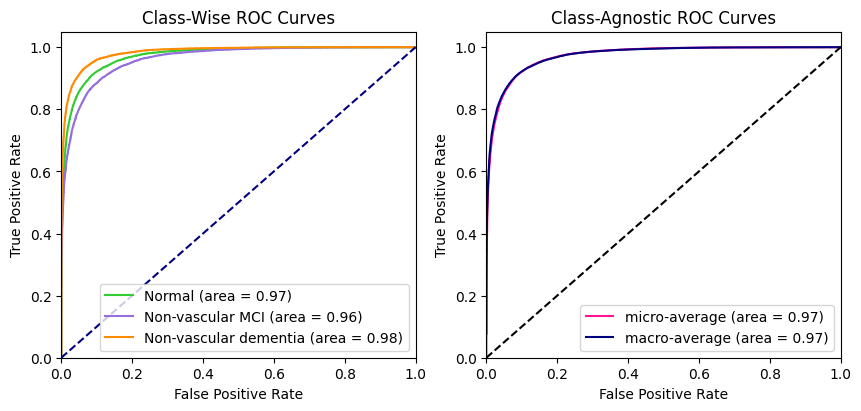

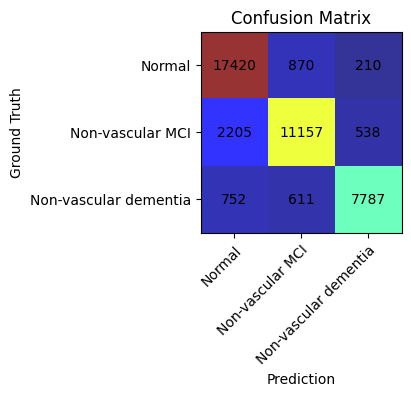

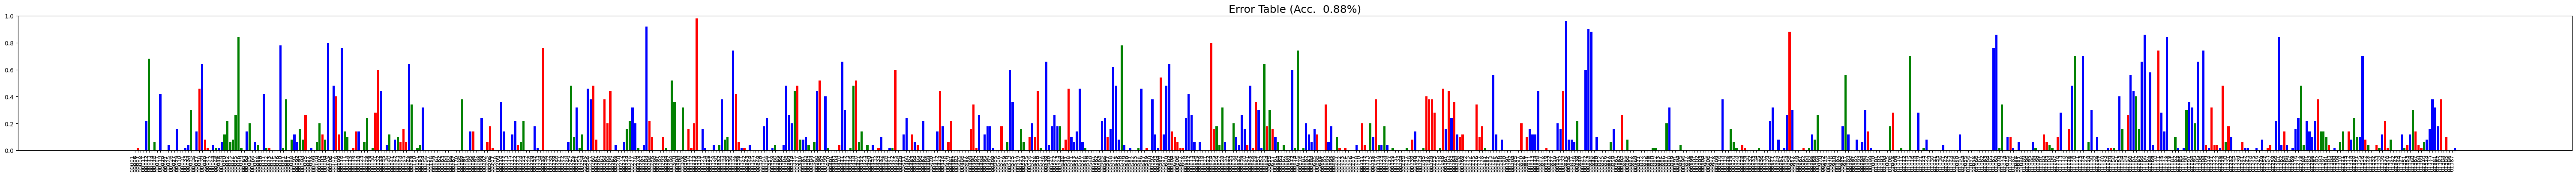

In [12]:
draw_roc_curve(train_score, train_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(train_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(train_error_table, use_wandb=False, fig_size=(60.0, 4.0))

### Validation set

In [13]:
_ = check_accuracy_extended_debug(model, val_loader, preprocess_test, config, repeat=50)
val_acc = _[0]
val_score = _[1]
val_target = _[2]
val_confusion = _[3]
val_error_table = _[4]
val_crop_timing = _[5]

print(val_acc)

58.73461538461538


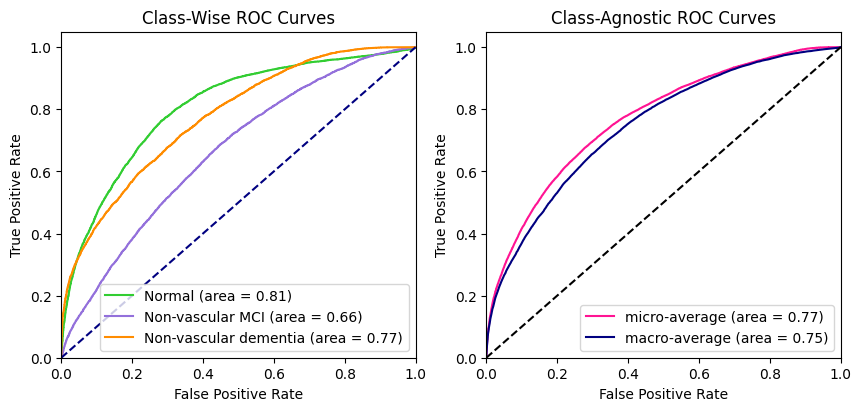

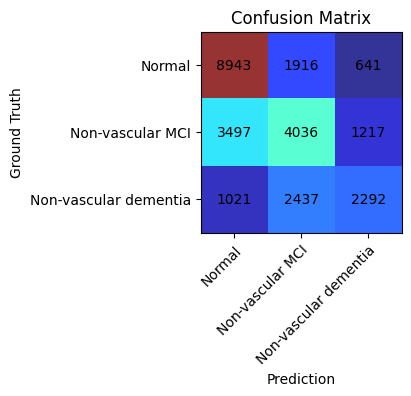

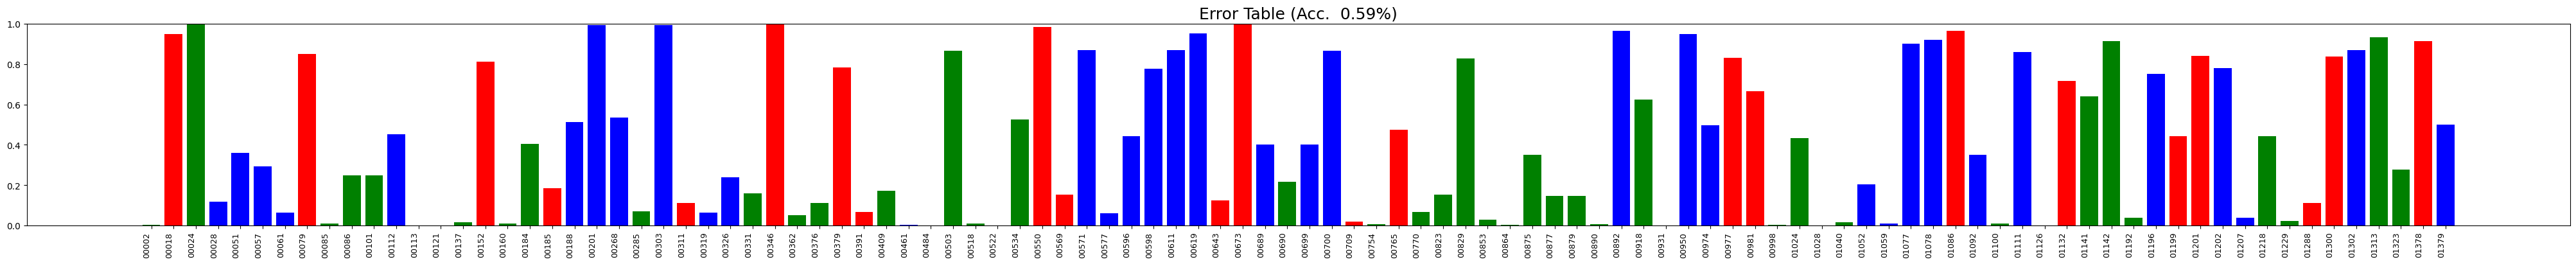

In [14]:
draw_roc_curve(val_score, val_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(val_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(val_error_table, use_wandb=False)

### Test set

In [15]:
_ = check_accuracy_extended_debug(model, test_loader, preprocess_test, config, repeat=50)
test_acc = _[0]
test_score = _[1]
test_target = _[2]
test_confusion = _[3]
test_error_table = _[4]
test_crop_timing = _[5]

print(test_acc)

66.47307692307692


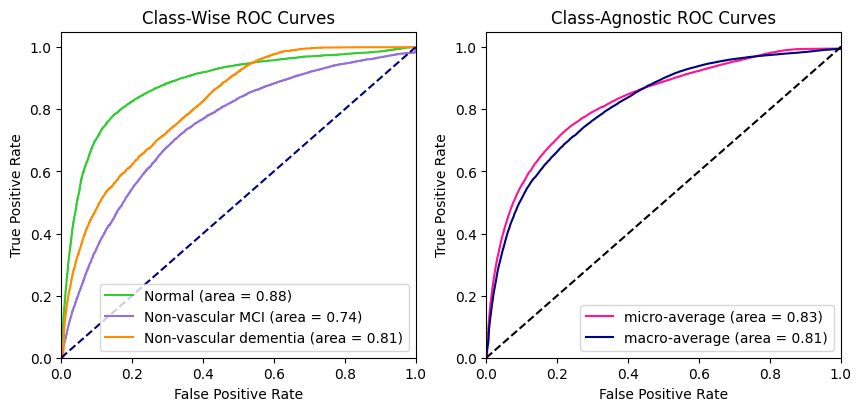

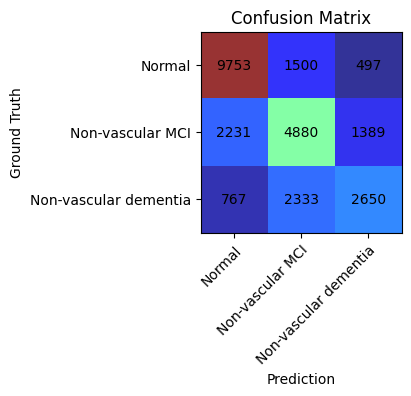

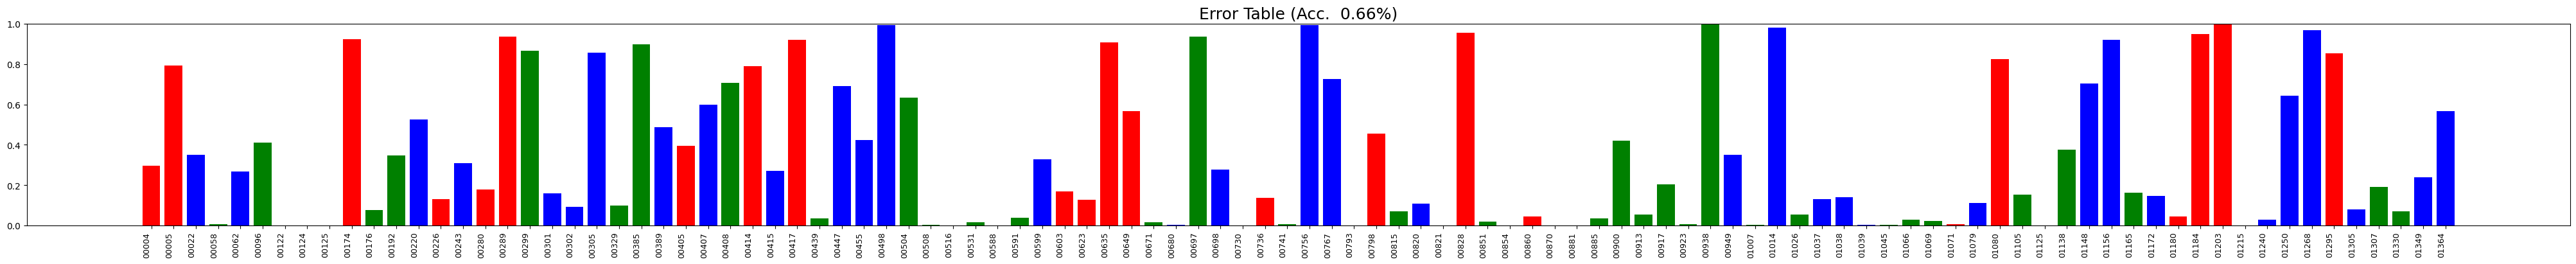

In [16]:
draw_roc_curve(test_score, test_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(test_error_table, use_wandb=False)

### Test set (with test-time augmentation)

In [17]:
_ = check_accuracy_extended_debug(model, test_loader_longer, preprocess_test, config, repeat=50)
test_longer_acc = _[0]
test_longer_score = _[1]
test_longer_target = _[2]
test_longer_confusion = _[3]
test_longer_error_table = _[4]
test_longer_crop_timing = _[5]

print(test_longer_acc)

71.27307692307693


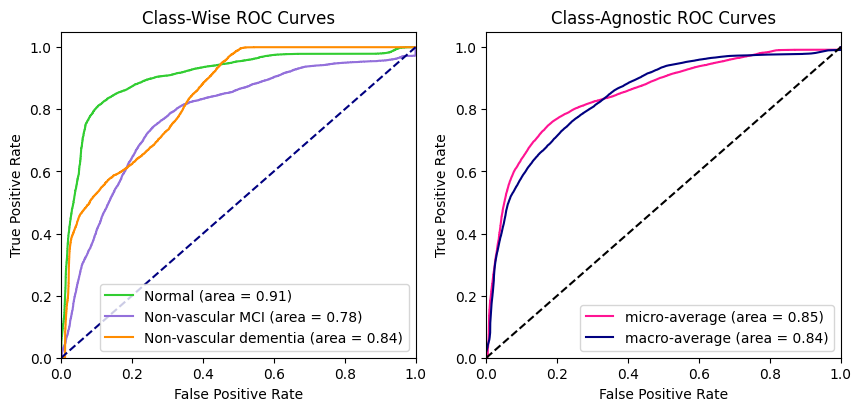

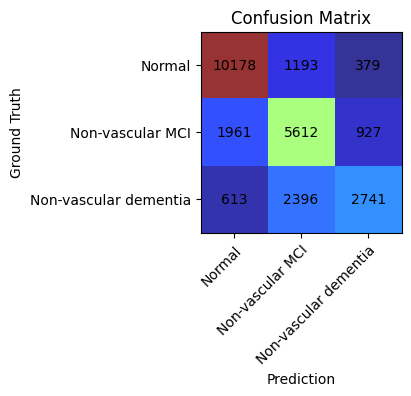

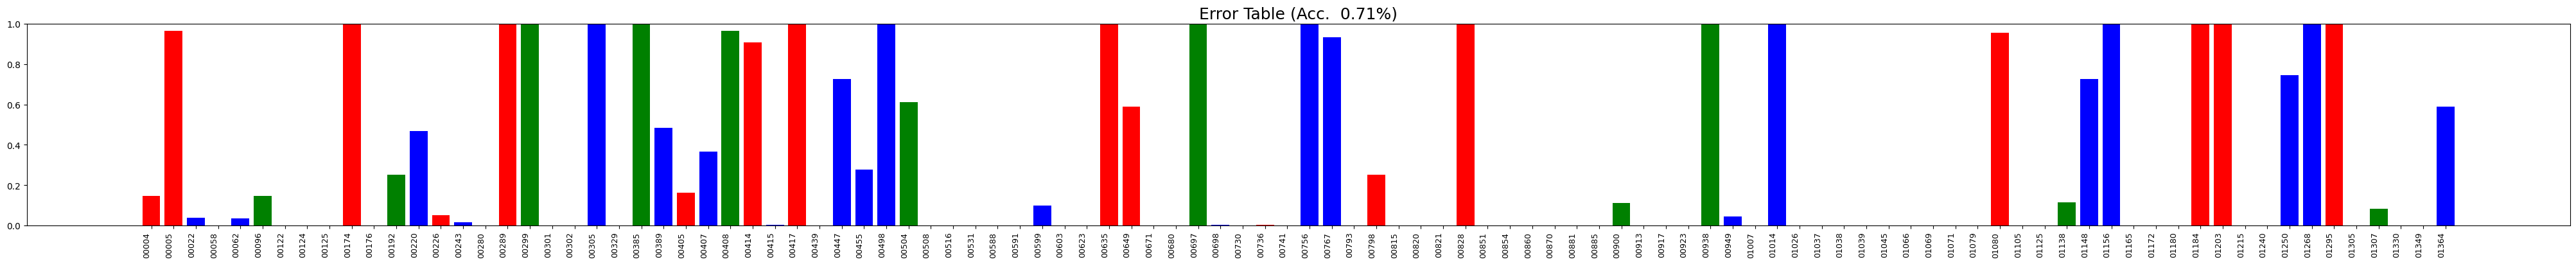

In [18]:
draw_roc_curve(test_longer_score, test_longer_target, config['class_label_to_name'], use_wandb=False)
draw_confusion(test_longer_confusion, config['class_label_to_name'], use_wandb=False)
draw_error_table(test_longer_error_table, use_wandb=False)

-----

## Examine whether the model has a bias related to the cropping starting time

In [19]:
train_pos = []
train_neg = []

for k, v in train_crop_timing.items():
    for i in range(v.get('pos', 0)):
        train_pos.append(k)
    for i in range(v.get('neg', 0)):
        train_neg.append(k)

##

val_pos = []
val_neg = []

for k, v in val_crop_timing.items():
    for i in range(v.get('pos', 0)):
        val_pos.append(k)
    for i in range(v.get('neg', 0)):
        val_neg.append(k)

##

test_pos = []
test_neg = []

for k, v in test_crop_timing.items():
    for i in range(v.get('pos', 0)):
        test_pos.append(k)
    for i in range(v.get('neg', 0)):
        test_neg.append(k)
        
##
        
test_longer_pos = []
test_longer_neg = []

for k, v in test_longer_crop_timing.items():
    for i in range(v.get('pos', 0)):
        test_longer_pos.append(k)
    for i in range(v.get('neg', 0)):
        test_longer_neg.append(k)

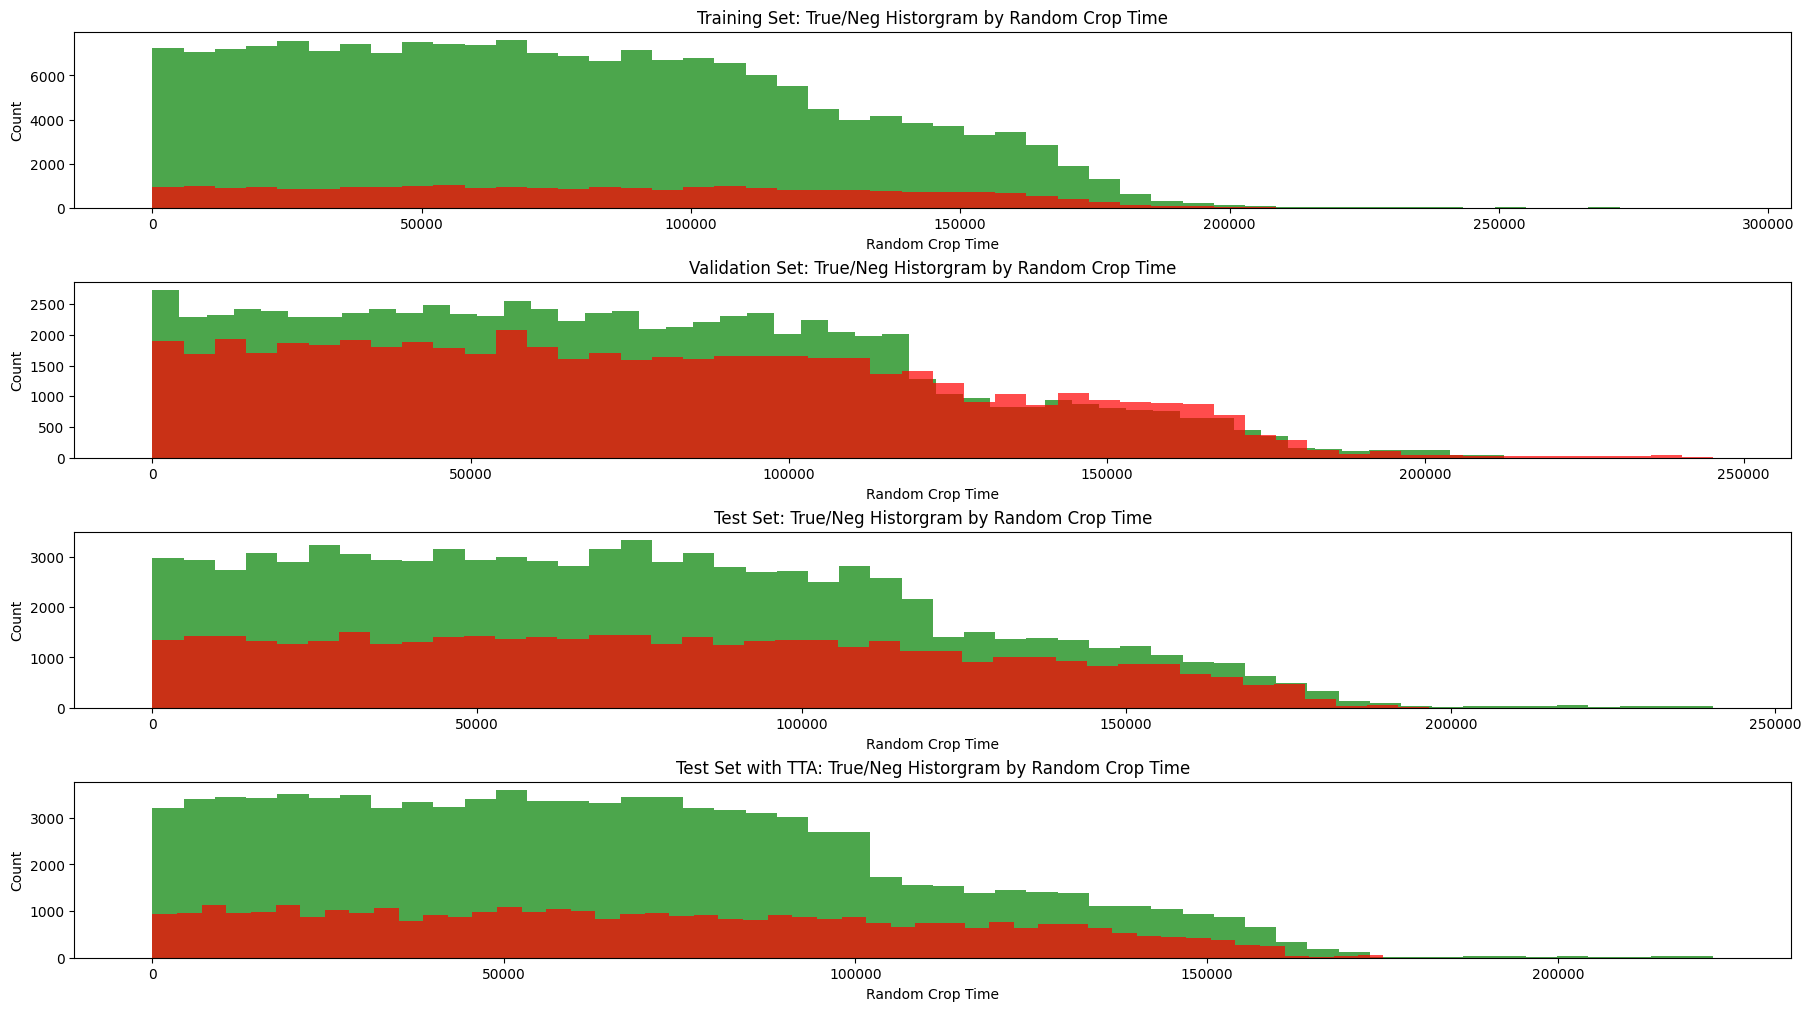

In [20]:
fig = plt.figure(num=1, clear=True, figsize=(18, 10), constrained_layout=True)
n_bins = 50
density = False

ax = fig.add_subplot(4, 1, 1)
ax.hist(train_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(train_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Training Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 2)
ax.hist(val_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(val_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Validation Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 3)
ax.hist(test_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(test_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

ax = fig.add_subplot(4, 1, 4)
ax.hist(test_longer_pos, bins=n_bins, color='g', alpha=0.7, density=density)
ax.hist(test_longer_neg, bins=n_bins, color='r', alpha=0.7, density=density)
ax.set_title(f'Test Set with TTA: True/Neg Historgram by Random Crop Time')
ax.set_xlabel('Random Crop Time')
ax.set_ylabel('Count')

plt.show()
fig.clear()
plt.close(fig)

-----

## Evaluate the model with length limit

In [21]:
with open(os.path.join(model_path, 'config.yaml'), 'r') as f:
    wandb_config = yaml.load(f, Loader=yaml.FullLoader)
    
config = {}
for k, v in wandb_config.items():
    if type(k) is str and (k.startswith('wandb') or k.startswith('_wandb')):
        continue
    config[k] = v['value']

In [22]:
# preprocessing procedure was changed.. (norm, channel drop) --> (channel drop, norm)
config['signal_mean'] = np.delete(np.array(config['signal_mean']), 19, 0)
config['signal_std'] = np.delete(np.array(config['signal_std']), 19, 0)

In [23]:
config['data_path'] = 'local/dataset/02_Curated_Data_210705/'
config['meta_path'] = 'local/dataset/02_Curated_Data_210705/metadata_debug.json'
config['file_format'] = 'feather'
config['minibatch'] = 256
config['crop_multiple'] = 5
# config['latency'] = 200 * 10  # 10 seconds
config['evaluation_phase'] = True
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
repeat = round(50 / config['crop_multiple'])
config['device'] = device

_ = build_dataset(config, verbose=True)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
test_loader_longer = _[3]
preprocess_train = _[4]
preprocess_test = _[5]

class_label_to_name: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']

----------------------------------------------------------------------------------------------------

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia

----------------------------------------------------------------------------------------------------

Train data label distribution	: [370, 278, 183] 831
Train data label distribution	: [46, 35, 23] 104
Train data label distribution	: [47, 34, 23] 104

----------------------------------------------------------------------------------------------------

composed_train: Compose(
    EegDropEKGChannel()
    EegLimitMaxLength(max_length=84000)
    EegRandomCrop(crop_length=2000, multiple=5, latency=0, return_timing=False)
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

composed_test: Compose(


In [24]:
# train
train_acc = check_accuracy(model, train_loader, preprocess_test, config, repeat=repeat)
val_acc = check_accuracy(model, val_loader, preprocess_test, config, repeat=repeat)
test_acc = check_accuracy(model, test_loader, preprocess_test, config, repeat=repeat)
test_longer_acc = check_accuracy(model, test_loader_longer, preprocess_test, config, repeat=repeat)

print(train_acc, val_acc, test_acc, test_longer_acc)

87.7713598074609 59.15384615384615 66.15384615384616 71.67307692307692


## Evaluate using random crop averaging

In [25]:
with open(os.path.join(model_path, 'config.yaml'), 'r') as f:
    wandb_config = yaml.load(f, Loader=yaml.FullLoader)
    
config = {}
for k, v in wandb_config.items():
    if type(k) is str and (k.startswith('wandb') or k.startswith('_wandb')):
        continue
    config[k] = v['value']

In [26]:
# preprocessing procedure was changed.. (norm, channel drop) --> (channel drop, norm)
config['signal_mean'] = np.delete(np.array(config['signal_mean']), 19, 0)
config['signal_std'] = np.delete(np.array(config['signal_std']), 19, 0)

In [27]:
config['data_path'] = 'local/dataset/02_Curated_Data_210705/'
config['meta_path'] = 'local/dataset/02_Curated_Data_210705/metadata_debug.json'
config['file_format'] = 'feather'
config['minibatch'] = 10
config['crop_multiple'] = 10
# config['latency'] = 200 * 10  # 10 seconds
config['evaluation_phase'] = True
# config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
repeat = round(50 / config['crop_multiple'])
config['device'] = device

_ = build_dataset(config, verbose=True)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
test_loader_longer = _[3]
preprocess_train = _[4]
preprocess_test = _[5]

class_label_to_name: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']

----------------------------------------------------------------------------------------------------

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia

----------------------------------------------------------------------------------------------------

Train data label distribution	: [370, 278, 183] 831
Train data label distribution	: [46, 35, 23] 104
Train data label distribution	: [47, 34, 23] 104

----------------------------------------------------------------------------------------------------

composed_train: Compose(
    EegDropEKGChannel()
    EegRandomCrop(crop_length=2000, multiple=10, latency=0, return_timing=False)
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

composed_test: Compose(
    EegDropEKGChannel()
    EegRandomCr

In [28]:
@torch.no_grad()
def check_accuracy_score_mean(model, loader, preprocess, config, repeat=1):
    model.eval()

    # for accuracy
    correct, total = (0, 0)

    with torch.no_grad():
        for k in range(repeat):
            for sample_batched in loader:
                # preprocessing (this includes to-device operation)
                preprocess(sample_batched)

                # apply model on whole batch directly on device
                x = sample_batched['signal']
                age = sample_batched['age']
                y = sample_batched['class_label']
                output = model(x, age)

                if config['criterion'] == 'cross-entropy':
                    s = F.softmax(output, dim=1)
                elif config['criterion'] == 'multi-bce':
                    s = torch.sigmoid(output)
                
                s = torch.mean(s, dim=0, keepdims=True)
                y = y[0]

                # calculate accuracy
                pred = s.argmax(dim=-1)
                correct += pred.squeeze().eq(y).sum().item()
                total += pred.shape[0]
    
    accuracy = 100.0 * correct / total
    
    return accuracy

In [29]:
# train
train_acc = check_accuracy_score_mean(model, train_loader, preprocess_test, config, repeat=repeat)
val_acc = check_accuracy_score_mean(model, val_loader, preprocess_test, config, repeat=repeat)
test_acc = check_accuracy_score_mean(model, test_loader, preprocess_test, config, repeat=repeat)
test_longer_acc = check_accuracy_score_mean(model, test_loader_longer, preprocess_test, config, repeat=repeat)

print(train_acc, val_acc, test_acc, test_longer_acc)

93.54993983152828 61.92307692307692 71.34615384615384 72.5


## Evaluate using random crop averaging and length limit

In [30]:
with open(os.path.join(model_path, 'config.yaml'), 'r') as f:
    wandb_config = yaml.load(f, Loader=yaml.FullLoader)
    
config = {}
for k, v in wandb_config.items():
    if type(k) is str and (k.startswith('wandb') or k.startswith('_wandb')):
        continue
    config[k] = v['value']

In [31]:
# preprocessing procedure was changed.. (norm, channel drop) --> (channel drop, norm)
config['signal_mean'] = np.delete(np.array(config['signal_mean']), 19, 0)
config['signal_std'] = np.delete(np.array(config['signal_std']), 19, 0)

In [32]:
config['data_path'] = 'local/dataset/02_Curated_Data_210705/'
config['meta_path'] = 'local/dataset/02_Curated_Data_210705/metadata_debug.json'
config['file_format'] = 'feather'
config['minibatch'] = 32
config['crop_multiple'] = 32
# config['latency'] = 200 * 10  # 10 seconds
config['evaluation_phase'] = True
config['signal_length_limit'] = 200 * 60 * 7  # 7 minutes
repeat = round(50 / config['crop_multiple'])
config['device'] = device

_ = build_dataset(config, verbose=True)
train_loader = _[0]
val_loader = _[1]
test_loader = _[2]
test_loader_longer = _[3]
preprocess_train = _[4]
preprocess_test = _[5]

class_label_to_name: ['Normal', 'Non-vascular MCI', 'Non-vascular dementia']

----------------------------------------------------------------------------------------------------

- There are 463 data belonging to Normal
- There are 347 data belonging to Non-vascular MCI
- There are 229 data belonging to Non-vascular dementia

----------------------------------------------------------------------------------------------------

Train data label distribution	: [370, 278, 183] 831
Train data label distribution	: [46, 35, 23] 104
Train data label distribution	: [47, 34, 23] 104

----------------------------------------------------------------------------------------------------

composed_train: Compose(
    EegDropEKGChannel()
    EegLimitMaxLength(max_length=84000)
    EegRandomCrop(crop_length=2000, multiple=32, latency=0, return_timing=False)
    EegToTensor()
)

----------------------------------------------------------------------------------------------------

composed_test: Compose(

In [33]:
# train
train_acc = check_accuracy_score_mean(model, train_loader, preprocess_test, config, repeat=repeat)
val_acc = check_accuracy_score_mean(model, val_loader, preprocess_test, config, repeat=repeat)
test_acc = check_accuracy_score_mean(model, test_loader, preprocess_test, config, repeat=repeat)
test_longer_acc = check_accuracy_score_mean(model, test_loader_longer, preprocess_test, config, repeat=repeat)

print(train_acc, val_acc, test_acc, test_longer_acc)

93.68231046931407 62.5 72.59615384615384 74.03846153846153
